### Setup

In [1]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/MADE/Final_Project")

In [2]:
import cv2
import glob
import time
import numpy as np

from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow

In [3]:
train_frames_dir = "data/frames/train/"
val_frames_dir = "data/frames/validation/"

print(len(os.listdir(train_frames_dir)))
print(len(os.listdir(val_frames_dir)))

145
47


In [4]:
train_aligned_faces_dir = "data/aligned_faces/train/"
val_aligned_faces_dir = "data/aligned_faces/validation/"

print(len(os.listdir(train_aligned_faces_dir)))
print(len(os.listdir(val_aligned_faces_dir)))

145
39


In [5]:
!pip install insightface -q

     |████████████████████████████████| 431 kB 8.3 MB/s 
     |████████████████████████████████| 12.7 MB 45.3 MB/s 
     |████████████████████████████████| 631 kB 65.2 MB/s 


In [6]:
!pip install onnxruntime -q

     |████████████████████████████████| 4.8 MB 7.9 MB/s 


In [7]:
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

### Utils

#### aligner

In [8]:
from skimage import transform as trans

src1 = np.array([[51.642, 50.115], [57.617, 49.990], [35.740, 69.007],
                 [51.157, 89.050], [57.025, 89.702]],
                dtype=np.float32)
#<--left
src2 = np.array([[45.031, 50.118], [65.568, 50.872], [39.677, 68.111],
                 [45.177, 86.190], [64.246, 86.758]],
                dtype=np.float32)

#---frontal
src3 = np.array([[39.730, 51.138], [72.270, 51.138], [56.000, 68.493],
                 [42.463, 87.010], [69.537, 87.010]],
                dtype=np.float32)

#-->right
src4 = np.array([[46.845, 50.872], [67.382, 50.118], [72.737, 68.111],
                 [48.167, 86.758], [67.236, 86.190]],
                dtype=np.float32)

#-->right profile
src5 = np.array([[54.796, 49.990], [60.771, 50.115], [76.673, 69.007],
                 [55.388, 89.702], [61.257, 89.050]],
                dtype=np.float32)

src = np.array([src1, src2, src3, src4, src5])
src_map = {112: src, 224: src * 2}

arcface_src = np.array(
    [[38.2946, 51.6963], [73.5318, 51.5014], [56.0252, 71.7366],
     [41.5493, 92.3655], [70.7299, 92.2041]],
    dtype=np.float32)

arcface_src = np.expand_dims(arcface_src, axis=0)

# In[66]:


# lmk is prediction; src is template
def estimate_norm(lmk, image_size=112, mode='arcface'):
    assert lmk.shape == (5, 2)
    tform = trans.SimilarityTransform()
    lmk_tran = np.insert(lmk, 2, values=np.ones(5), axis=1)
    min_M = []
    min_index = []
    min_error = float('inf')
    if mode == 'arcface':
        if image_size == 112:
            src = arcface_src
        else:
            src = float(image_size) / 112 * arcface_src
    else:
        src = src_map[image_size]
    for i in np.arange(src.shape[0]):
        tform.estimate(lmk, src[i])
        M = tform.params[0:2, :]
        results = np.dot(M, lmk_tran.T)
        results = results.T
        error = np.sum(np.sqrt(np.sum((results - src[i])**2, axis=1)))
        #         print(error)
        if error < min_error:
            min_error = error
            min_M = M
            min_index = i
    return min_M, min_index


def norm_crop(img, landmark, image_size=112, mode='arcface'):
    M, pose_index = estimate_norm(landmark, image_size, mode)
    warped = cv2.warpAffine(img, M, (image_size, image_size), borderValue=0.0)
    return warped

#### detection

In [9]:
app = FaceAnalysis()
app.prepare(ctx_id=-1, det_size=(640, 640)) # cpu
# app.prepare(ctx_id=0, det_size=(640, 640)) # gpu

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 40822.85KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [10]:
def get_retina_face_aligned_face(image_path):
  img = cv2.imread(image_path)
  faces = app.get(img)
  if len(faces) == 0:
    return None, None, None
  face = faces[0]
  warped = norm_crop(img, face.kps, image_size=112, mode='arcface')
  return warped, face.bbox, face.kps

In [11]:
# image_path = glob.glob(val_frames_dir + "*/*.jpg")[0]
image_path = train_frames_dir + '/subject_40_Vid_6/frame_0.jpg'

In [12]:
%time
aligned_face, bbox, landmarks = get_retina_face_aligned_face(image_path)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


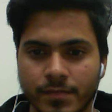

In [13]:
cv2_imshow(aligned_face)

In [14]:
bbox

array([446.6047 ,  91.51712, 680.98676, 400.97192], dtype=float32)

In [15]:
landmarks

array([[502.7058 , 226.55237],
       [606.812  , 215.09752],
       [557.01544, 278.9511 ],
       [524.20844, 334.41333],
       [614.2554 , 323.75818]], dtype=float32)

In [16]:
# for image_path in tqdm(glob.glob(train_frames_dir + '/subject_40_Vid_6/*.jpg')):
#   aligned_face, retina_bbox = get_retina_face_aligned_face(image_path)
  
#   if aligned_face is not None:
#     subdir = "data/aligned_faces/tmp/" + image_path.split("/")[-2]
#     if not os.path.exists(subdir):
#       os.mkdir(subdir)
#     save_path = os.path.join(subdir, image_path.split("/")[-1].replace(".jpg", "_face.jpg"))
#     cv2.imwrite(save_path, aligned_face)
#   else:
#     print(f"no face image_path: {image_path}")

In [17]:
# save_path

### Main

In [21]:
import json

def update_list_of_items(filepath, new_item):
  if not os.path.exists(filepath):
    list_of_items = []
  else:
    with open(filepath, "r") as f:
      list_of_items = json.loads(f.read())
  
  list_of_items.append(new_item)

  with open(filepath, "w") as f:
    f.write(json.dumps(list_of_items))

  print(f"Updated '{filepath}'.\n")

In [20]:
train_already_proccessed_file = "notebooks/aligned_faces_train_already_proccessed_sub_folders"

In [21]:
if not os.path.exists(train_already_proccessed_file):
  train_already_proccessed_sub_folders = []
else:
  with open(train_already_proccessed_file, "r") as f:
    train_already_proccessed_sub_folders = json.loads(f.read())

len(train_already_proccessed_sub_folders)

127

In [22]:
# train frames

for i, sub_folder in enumerate(sorted(os.listdir(train_frames_dir))):
  if sub_folder in train_already_proccessed_sub_folders:
    print(f"{ i + 1} / {len(os.listdir(train_frames_dir))}, {sub_folder} Already processed, skipping it.")
    continue

  print(f"{ i + 1} / {len(os.listdir(train_frames_dir))}, {sub_folder}")
  not_found = 0
  for frame in tqdm(sorted(os.listdir(os.path.join(train_frames_dir, sub_folder)))):
    if not frame.endswith(".jpg"):
      continue

    frame_path = os.path.join(train_frames_dir, sub_folder, frame)

    aligned_face, bbox, landmarks = get_retina_face_aligned_face(frame_path)

    if aligned_face is None:
      not_found += 1
      continue

    # save retina bbox
    bbox_filepath = frame_path.replace(".jpg", "_retina_bbox.txt")
    with open(bbox_filepath, "w") as fin:
      fin.write(" ".join(map(str, map(int, list(bbox)))))
    
    # save landmarks
    landmarks_filepath = frame_path.replace(".jpg", "_retina_landmarks.npy")
    np.save(landmarks_filepath, landmarks)

    # save aligned face
    subdir = os.path.join(train_aligned_faces_dir, sub_folder)
    if not os.path.exists(subdir):
      os.mkdir(subdir)
      print(f"created new: {subdir}")

    save_fname = frame.replace(".jpg", "_face.jpg")
    save_path = os.path.join(subdir, save_fname)
    cv2.imwrite(save_path, aligned_face)

  print(f"not found: {not_found}")

  update_list_of_items(filepath=train_already_proccessed_file, new_item=sub_folder)

1 / 145, subject_25_Vid_5 Already processed, skipping it.
2 / 145, subject_26_Vid_1 Already processed, skipping it.
3 / 145, subject_26_Vid_2 Already processed, skipping it.
4 / 145, subject_26_Vid_4 Already processed, skipping it.
5 / 145, subject_26_Vid_5 Already processed, skipping it.
6 / 145, subject_26_Vid_5_1 Already processed, skipping it.
7 / 145, subject_26_Vid_5_2 Already processed, skipping it.
8 / 145, subject_26_Vid_7 Already processed, skipping it.
9 / 145, subject_27_Vid_1 Already processed, skipping it.
10 / 145, subject_29_Vid_6 Already processed, skipping it.
11 / 145, subject_29_Vid_7 Already processed, skipping it.
12 / 145, subject_30_Vid_1 Already processed, skipping it.
13 / 145, subject_30_Vid_2 Already processed, skipping it.
14 / 145, subject_30_Vid_3 Already processed, skipping it.
15 / 145, subject_30_Vid_4 Already processed, skipping it.
16 / 145, subject_30_Vid_5 Already processed, skipping it.
17 / 145, subject_32_Vid_1 Already processed, skipping it.
18

  0%|          | 0/2182 [00:00<?, ?it/s]

not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

129 / 145, subject_80_Vid_2


  0%|          | 0/954 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_80_Vid_2
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

130 / 145, subject_80_Vid_3


  0%|          | 0/994 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_80_Vid_3
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

131 / 145, subject_80_Vid_4


  0%|          | 0/986 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_80_Vid_4
not found: 1
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

132 / 145, subject_80_Vid_5


  0%|          | 0/931 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_80_Vid_5
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

133 / 145, subject_80_Vid_6


  0%|          | 0/798 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_80_Vid_6
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

134 / 145, subject_81_Vid_7


  0%|          | 0/2670 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_81_Vid_7
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

135 / 145, subject_82_Vid_7


  0%|          | 0/1664 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_82_Vid_7
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

136 / 145, subject_83_Vid_7


  0%|          | 0/3275 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_83_Vid_7
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

137 / 145, subject_84_Vid_1


  0%|          | 0/1209 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_1
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

138 / 145, subject_84_Vid_2


  0%|          | 0/958 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_2
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

139 / 145, subject_84_Vid_3


  0%|          | 0/923 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_3
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

140 / 145, subject_84_Vid_4


  0%|          | 0/1014 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_4
not found: 1
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

141 / 145, subject_84_Vid_5


  0%|          | 0/903 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_5
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

142 / 145, subject_84_Vid_6


  0%|          | 0/791 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_84_Vid_6
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

143 / 145, subject_85_Vid_7


  0%|          | 0/1437 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_85_Vid_7
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

144 / 145, subject_86_Vid_7


  0%|          | 0/1421 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_86_Vid_7
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.

145 / 145, subject_87_Vid_3


  0%|          | 0/1531 [00:00<?, ?it/s]

created new: data/aligned_faces/train/subject_87_Vid_3
not found: 0
Updated 'notebooks/aligned_faces_train_already_proccessed_sub_folders'.



In [23]:
len(glob.glob(train_frames_dir + "/*/*.jpg"))

118202

In [25]:
len(glob.glob(train_aligned_faces_dir + "/*/*.jpg"))

118049

In [22]:
val_already_proccessed_file = "notebooks/aligned_faces_val_already_proccessed_sub_folders"

In [23]:
if not os.path.exists(val_already_proccessed_file):
  val_already_proccessed_sub_folders = []
else:
  with open(val_already_proccessed_file, "r") as f:
    val_already_proccessed_sub_folders = json.loads(f.read())

len(val_already_proccessed_sub_folders)

38

In [24]:
# validation frames

for i, sub_folder in enumerate(sorted(os.listdir(val_frames_dir))):
  if sub_folder in val_already_proccessed_sub_folders:
    print(f"{ i + 1} / {len(os.listdir(val_frames_dir))}, {sub_folder} Already processed, skipping it.")
    continue

  print(f"{ i + 1} / {len(os.listdir(val_frames_dir))}, {sub_folder}")
  not_found = 0
  for frame in tqdm(sorted(os.listdir(os.path.join(val_frames_dir, sub_folder)))):
    if not frame.endswith(".jpg"):
      continue

    frame_path = os.path.join(val_frames_dir, sub_folder, frame)

    aligned_face, bbox, landmarks = get_retina_face_aligned_face(frame_path)

    if aligned_face is None:
      not_found += 1
      continue

    # save retina bbox
    bbox_filepath = frame_path.replace(".jpg", "_retina_bbox.txt")
    with open(bbox_filepath, "w") as fin:
      fin.write(" ".join(map(str, map(int, list(bbox)))))
    
    # save landmarks
    landmarks_filepath = frame_path.replace(".jpg", "_retina_landmarks.npy")
    np.save(landmarks_filepath, landmarks)

    # save aligned face
    subdir = os.path.join(val_aligned_faces_dir, sub_folder)
    if not os.path.exists(subdir):
      os.mkdir(subdir)
      print(f"created new: {subdir}")

    save_fname = frame.replace(".jpg", "_face.jpg")
    save_path = os.path.join(subdir, save_fname)
    cv2.imwrite(save_path, aligned_face)

  print(f"not found: {not_found}")

  update_list_of_items(filepath=val_already_proccessed_file, new_item=sub_folder)

1 / 47, subject_10_Vid_6 Already processed, skipping it.
2 / 47, subject_11_Vid_6 Already processed, skipping it.
3 / 47, subject_12_Vid_6 Already processed, skipping it.
4 / 47, subject_13_Vid_6 Already processed, skipping it.
5 / 47, subject_14_Vid_6 Already processed, skipping it.
6 / 47, subject_15_Vid_6 Already processed, skipping it.
7 / 47, subject_16_Vid_6 Already processed, skipping it.
8 / 47, subject_17_Vid_6 Already processed, skipping it.
9 / 47, subject_18_Vid_6 Already processed, skipping it.
10 / 47, subject_19_Vid_6 Already processed, skipping it.
11 / 47, subject_1_Vid_1 Already processed, skipping it.
12 / 47, subject_1_Vid_2 Already processed, skipping it.
13 / 47, subject_1_Vid_3 Already processed, skipping it.
14 / 47, subject_1_Vid_4 Already processed, skipping it.
15 / 47, subject_1_Vid_5 Already processed, skipping it.
16 / 47, subject_20_Vid_1 Already processed, skipping it.
17 / 47, subject_20_Vid_2 Already processed, skipping it.
18 / 47, subject_20_Vid_3 Al

  0%|          | 0/5316 [00:00<?, ?it/s]

not found: 2
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

40 / 47, subject_6_Vid_6


  0%|          | 0/3420 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_6_Vid_6
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

41 / 47, subject_7_Vid_1


  0%|          | 0/2129 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_7_Vid_1
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

42 / 47, subject_7_Vid_2


  0%|          | 0/1649 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_7_Vid_2
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

43 / 47, subject_7_Vid_3


  0%|          | 0/1753 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_7_Vid_3
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

44 / 47, subject_7_Vid_4


  0%|          | 0/1702 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_7_Vid_4
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

45 / 47, subject_7_Vid_5


  0%|          | 0/1630 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_7_Vid_5
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

46 / 47, subject_8_Vid_6


  0%|          | 0/1726 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_8_Vid_6
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.

47 / 47, subject_9_Vid_6


  0%|          | 0/1646 [00:00<?, ?it/s]

created new: data/aligned_faces/validation/subject_9_Vid_6
not found: 0
Updated 'notebooks/aligned_faces_val_already_proccessed_sub_folders'.



In [25]:
len(glob.glob(val_frames_dir + "/*/*.jpg"))

49038

In [26]:
len(glob.glob(val_aligned_faces_dir + "/*/*.jpg"))

49006